In [1]:
%matplotlib qt4
%matplotlib inline

# DM3 Translator
* This file is used to translate the raw DM3 data file into standard H5 file. 

* The data will be initially processed and stored in the same file for future analysis. 
 - The process includes: ZLP alignment, Thickness computing, ZLP substraction. 
 - Please be aware that the data is limited to low-loss data so far. <br>
 - If the raw data is core-loss signal, please include additional low-loss data for the ZLP alignment.

# Import Software:
* Standard distribution (include numpy, scipy, matplotlib, sci-kit learn).
* **hyperspy** : can load and process DM3 data directly. (import hyperspy.api, not hyperspy)
* **pycroscopy** : mainly used here for plotting purposes only. 
* **hyperspy_tools** : to extract EELS zlp.

In [2]:
#Import packages

# Ensure that this code works on both python 2 and python 3
from __future__ import division, print_function, absolute_import, unicode_literals

# basic numeric computation:
import numpy as np

# basic system operation:
import os

# The package used for creating and manipulating HDF5 files:
import h5py
import hyperspy.api as hs

# To extract EELS ZLP, put 'eels.py' from hyperspy_tools in the python path and then import here:
from eels import extract_ZLP

# Plotting and visualization:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# multivariate analysis:
from sklearn.cluster import KMeans
from sklearn.decomposition import NMF

# finally import pycroscopy:
import pycroscopy as px

D:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Load DM3 data:
* Use **hyperspy** to read DM3 data.
* Reshape the data as h5 file required.
## Tips:
* The 'np.reshape' will reshape the matrix acoording to the C memory order, i.e. the most rapidly changing index comes last: (k,j,i)
* The h5 file for pycroscopy requires the 3D EELS data (i,j,k) to be flattened as 2D (i*j, k) in the C memory order as well, i.e. the order of row in the flattened data is [0,0],[0,1]...[0,N-1],[1,0],[1,1] ...

In [3]:
folder_path=''
file_name='EELS Spectrum Image.dm3'

folder_path = 'D:/Books/research/IMAGE/20180110_TMD/'
folder_name = '150_3'
file_name = folder_path + folder_name + '/EELS Spectrum Image.dm4'
raw = hs.load(file_name,signal_type='EELS')
#raw = hs.load(folder_path+file_name,signal_type='EELS')
data = raw.data
np.shape(data)
raw.metadata

D:\Anaconda3\lib\site-packages\hyperspy\io.py:341: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  if np.issubdtype(dtype, complex):


(22, 22, 2048)

├── Acquisition_instrument
│   └── TEM
│       ├── Detector
│       │   └── EELS
│       │       ├── aperture_size = 5.0
│       │       ├── collection_angle = 52.083333333333336
│       │       ├── frame_number = 1
│       │       └── spectrometer = GIF Abruzzi
│       ├── Stage
│       │   ├── tilt_alpha = 1.7100000381469727
│       │   ├── x = -0.055094000000000004
│       │   ├── y = 0.069595796875
│       │   └── z = -0.051299
│       ├── acquisition_mode = STEM
│       ├── beam_current = 0.0
│       ├── beam_energy = 200.0
│       ├── camera_length = 20.0
│       ├── convergence_angle = 4.5
│       ├── magnification = 15000000.0
│       └── microscope = []
├── General
│   ├── original_filename = EELS Spectrum Image.dm4
│   └── title = EELS Spectrum Image
└── Signal
    ├── Noise_properties
    │   └── Variance_linear_model
    │       ├── gain_factor = 1.0
    │       └── gain_offset = 0.0
    ├── binned = True
    ├── quantity = Intensity (Counts)
    └── signal_type = EELS

In [4]:
count = 0
data_shape = np.shape(data)
ind_mat = np.zeros(data_shape)
for (ind1,ind2,ind3), val in np.ndenumerate(data):
    ind_mat[ind1,ind2,ind3] = count
    count += 1
#print(np.shape(data))

h5_data = np.reshape(data,(-1,data_shape[2]))
h5_ind = np.reshape(ind_mat,(-1,data_shape[2]))
##present the ordering:
#make a function to transfer count of the memory order to 3D position.
#def getindex(number):
#    id1 = number//(data_shape[2]*data_shape[1])
#    res1 = number%(data_shape[2]*data_shape[1])
#    id2 = res1//data_shape[2]
#    id3 = res1 - id2*data_shape[2]
#    return (id1,id2,id3)

#for i in range(30):
#    print(getindex(h5_ind[i,0]))


# Prepare Ancillary Data and Translate into H5 file:
* Create the new file path.
* Specify the spectroscopic axis: minimum of the axis, and dispersion
* Translate the data into h5 file using **NumpyTranslator**

In [5]:
h5_path = os.path.join(folder_path, file_name[:-4] + '.h5')
print('The h5 file will be saved in the following path:')
print(h5_path)

image_cal = raw.original_metadata.ImageList.TagGroup0.ImageData.Calibrations.Dimension
pos_cal = image_cal.TagGroup0
spec_cal = image_cal.TagGroup2
print(image_cal)

# Generate the x / spectroscopic axis:
pos_pixel_size = pos_cal.Scale
pos_units = pos_cal.Units


spec_pixel_size = spec_cal.Scale
spec_min = (0-spec_cal.Origin)*spec_cal.Scale
spec_units = spec_cal.Units
spec_vec = np.linspace(spec_min, spec_min+spec_pixel_size*(data_shape[2]-1), data_shape[2])


# Generate attributes dictionary:
parm_dict=dict()
tem = raw.metadata.Acquisition_instrument.TEM
parm_dict['beam_energy'] = tem.beam_energy
parm_dict['convergence_angle'] = tem.convergence_angle
parm_dict['EELS_collection_angle']=tem.Detector.EELS.collection_angle
parm_dict['num_rows']=data_shape[0]
parm_dict['num_cols']=data_shape[1]
parm_dict['spec_length']=data_shape[2]
parm_dict['spec_axis']=spec_vec
parm_dict['spec_pixel_size']=spec_pixel_size
parm_dict['spec_unit']=spec_units
parm_dict['spatial_pixel_size']=pos_pixel_size
parm_dict['spatial_unit']=pos_units
for key in parm_dict:
    print(key, ':', parm_dict[key])

The h5 file will be saved in the following path:
D:/Books/research/IMAGE/20180110_TMD/150_3/EELS Spectrum Image.h5
├── TagGroup0
│   ├── Origin = 0.0
│   ├── Scale = 0.6330757737159729
│   └── Units = nm
├── TagGroup1
│   ├── Origin = 0.0
│   ├── Scale = 0.6330757737159729
│   └── Units = nm
└── TagGroup2
    ├── Origin = 200.0
    ├── Scale = 0.05000000074505806
    └── Units = eV

beam_energy : 200.0
convergence_angle : 4.5
EELS_collection_angle : 52.083333333333336
num_rows : 22
num_cols : 22
spec_length : 2048
spec_axis : [-10.00000015  -9.95000015  -9.90000015 ...  92.25000137  92.30000138
  92.35000138]
spec_pixel_size : 0.05000000074505806
spec_unit : eV
spatial_pixel_size : 0.6330757737159729
spatial_unit : nm


In [6]:
tran = px.io.NumpyTranslator()
h5_path = tran.translate(h5_path, h5_data, data_shape[0], data_shape[1], 
                         qty_name='Count', data_unit='', spec_name='Energy Loss',
                         spec_unit='eV', spec_val=spec_vec, spatial_unit='um', 
                         data_type='STS',translator_name='ASC', parms_dict=parm_dict)

## Process the raw data:
We will initially process the raw data from DM3 file for future analysis. Please be aware that the data is limited to low-loss data so far. If the raw data is core-loss signal, please include additional low-loss data for the ZLP alignment.
 - The initial process includes:
  - ZLP alignment (this file is limited to low-loss data)
  - Thickness computing
  - ZLP substraction

**1. Align ZLP with subpixel accuracy on.**

D:\Anaconda3\lib\site-packages\hyperspy\io.py:341: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  if np.issubdtype(dtype, complex):



Initial ZLP position statistics
-------------------------------
Summary statistics
------------------
mean:	0.000
std:	0.008

min:	-0.049
Q1:	0.001
median:	0.001
Q3:	0.001
max:	0.001


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

Text(0,0.5,'ZLP Positions')

[]

(array([], dtype=float64), <a list of 0 Text yticklabel objects>)

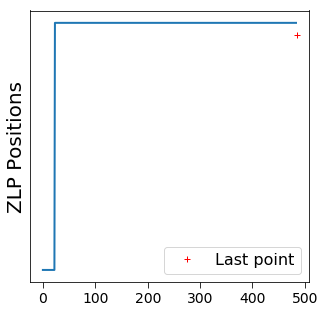

In [8]:
raw.align_zero_loss_peak(subpixel=True)
new_axes = raw.axes_manager['Energy loss']
new_spec_vec = np.linspace(new_axes.offset, new_axes.offset+new_axes.scale*(new_axes.size-1), new_axes.size)
zlp_pos = raw.estimate_zero_loss_peak_centre()
zlp_sort = np.sort(zlp_pos,axis=None)
plt.plot(zlp_sort)
plt.ylabel('ZLP Positions', fontsize=20)
plt.gca().set_yticks([])
plt.yticks()
plt.plot(np.shape(zlp_sort)[0],0,'r+',label='Last point')
plt.legend()

D:\Anaconda3\lib\site-packages\hyperspy\io.py:341: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  if np.issubdtype(dtype, complex):
D:\Anaconda3\lib\site-packages\hyperspy\signal.py:1990: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  if np.issubdtype(navigator().dtype, complex):
D:\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mp

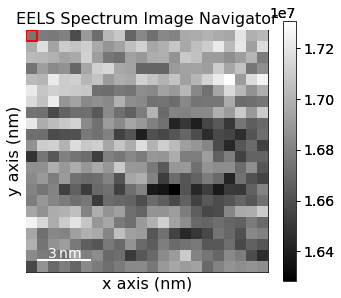

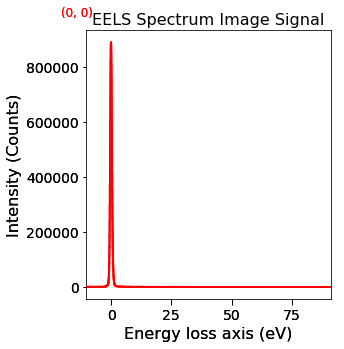

In [9]:
raw.plot()

**2. Compute the thickness.**

In [10]:
thickness = raw.estimate_thickness(0.01).data
print(thickness.shape)

D:\Anaconda3\lib\site-packages\hyperspy\io.py:341: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  if np.issubdtype(dtype, complex):


(22, 22)


**3. Extract ZLP signal and get the inelastic signal.**<br>

* Remember to translate the data into the format pycroscopy required

In [11]:
zlp, sig = extract_ZLP(raw,range_factor=(-10, 6),return_inelastic=True,print_output=True)
zlp_data = np.reshape(zlp.data,(-1,zlp.data.shape[2]))
sig_data = np.reshape(sig.data,(-1,sig.data.shape[2]))

D:\Anaconda3\lib\site-packages\hyperspy\io.py:341: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  if np.issubdtype(dtype, complex):


Fitting initial Gaussian to determine fitting range


A Jupyter Widget


Mean HWHM of ZLP is 0.42 eV
Fitting Signal in range (-10, 6)*HWHM...


A Jupyter Widget


Fit results:
Components	Parameter	Value
Gaussian
		A	1.17848e+07
		centre	0.0424637
		sigma	0.383751
Lorentzian
		A	4.15509e+06
		centre	-0.0679982
		gamma	0.333129

Calculating inelastic portion of spectrum:


D:\Anaconda3\lib\site-packages\hyperspy\misc\math_tools.py:61: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  return np.issubdtype(number, np.float)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

Calculating ZLP portion of spectrum:


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

"Residual" mean: nan
"Residual" std dev: nan


In [17]:
raw.original_metadata.ImageList.TagGroup0.ImageData.Calibrations.Dimension

├── TagGroup0
│   ├── Origin = 0.0
│   ├── Scale = 0.6330757737159729
│   └── Units = nm
├── TagGroup1
│   ├── Origin = 0.0
│   ├── Scale = 0.6330757737159729
│   └── Units = nm
└── TagGroup2
    ├── Origin = 200.0
    ├── Scale = 0.05000000074505806
    └── Units = eV

In [73]:
# Next, impute the missing values
test = deepcopy(sig)
t = test.data
sp = np.shape(test.data)
for i in range(sp[0]):
    for j in range(sp[1]):
        for k in range(sp[2]):
            if np.isnan(test.data[i,j,k]):
                print('Found nan! ({},{},{})'.format(i,j,k))

Found it! (15,11,143)
Found it! (15,11,144)
Found it! (15,11,145)
Found it! (15,11,146)
Found it! (15,11,147)
Found it! (15,11,148)
Found it! (15,11,149)
Found it! (15,11,150)
Found it! (15,11,151)
Found it! (15,11,152)
Found it! (15,11,153)
Found it! (15,11,154)
Found it! (15,11,155)
Found it! (15,11,156)
Found it! (15,11,157)
Found it! (15,11,158)
Found it! (15,11,159)
Found it! (15,11,160)
Found it! (15,11,161)
Found it! (15,11,162)
Found it! (15,11,163)
Found it! (15,11,164)
Found it! (15,11,165)
Found it! (15,11,166)
Found it! (15,11,167)
Found it! (15,11,168)
Found it! (15,11,169)
Found it! (15,11,170)
Found it! (15,11,171)
Found it! (15,11,172)
Found it! (15,11,173)
Found it! (15,11,174)
Found it! (15,11,175)
Found it! (15,11,176)
Found it! (15,11,177)
Found it! (15,11,178)
Found it! (15,11,179)
Found it! (15,11,180)
Found it! (15,11,181)
Found it! (15,11,182)
Found it! (15,11,183)
Found it! (15,11,184)
Found it! (15,11,185)
Found it! (15,11,186)
Found it! (15,11,187)
Found it! 

Found it! (15,11,887)
Found it! (15,11,888)
Found it! (15,11,889)
Found it! (15,11,890)
Found it! (15,11,891)
Found it! (15,11,892)
Found it! (15,11,893)
Found it! (15,11,894)
Found it! (15,11,895)
Found it! (15,11,896)
Found it! (15,11,897)
Found it! (15,11,898)
Found it! (15,11,899)
Found it! (15,11,900)
Found it! (15,11,901)
Found it! (15,11,902)
Found it! (15,11,903)
Found it! (15,11,904)
Found it! (15,11,905)
Found it! (15,11,906)
Found it! (15,11,907)
Found it! (15,11,908)
Found it! (15,11,909)
Found it! (15,11,910)
Found it! (15,11,911)
Found it! (15,11,912)
Found it! (15,11,913)
Found it! (15,11,914)
Found it! (15,11,915)
Found it! (15,11,916)
Found it! (15,11,917)
Found it! (15,11,918)
Found it! (15,11,919)
Found it! (15,11,920)
Found it! (15,11,921)
Found it! (15,11,922)
Found it! (15,11,923)
Found it! (15,11,924)
Found it! (15,11,925)
Found it! (15,11,926)
Found it! (15,11,927)
Found it! (15,11,928)
Found it! (15,11,929)
Found it! (15,11,930)
Found it! (15,11,931)
Found it! 

Found it! (15,12,429)
Found it! (15,12,430)
Found it! (15,12,431)
Found it! (15,12,432)
Found it! (15,12,433)
Found it! (15,12,434)
Found it! (15,12,435)
Found it! (15,12,436)
Found it! (15,12,437)
Found it! (15,12,438)
Found it! (15,12,439)
Found it! (15,12,440)
Found it! (15,12,441)
Found it! (15,12,442)
Found it! (15,12,443)
Found it! (15,12,444)
Found it! (15,12,445)
Found it! (15,12,446)
Found it! (15,12,447)
Found it! (15,12,448)
Found it! (15,12,449)
Found it! (15,12,450)
Found it! (15,12,451)
Found it! (15,12,452)
Found it! (15,12,453)
Found it! (15,12,454)
Found it! (15,12,455)
Found it! (15,12,456)
Found it! (15,12,457)
Found it! (15,12,458)
Found it! (15,12,459)
Found it! (15,12,460)
Found it! (15,12,461)
Found it! (15,12,462)
Found it! (15,12,463)
Found it! (15,12,464)
Found it! (15,12,465)
Found it! (15,12,466)
Found it! (15,12,467)
Found it! (15,12,468)
Found it! (15,12,469)
Found it! (15,12,470)
Found it! (15,12,471)
Found it! (15,12,472)
Found it! (15,12,473)
Found it! 

Found it! (15,13,154)
Found it! (15,13,155)
Found it! (15,13,156)
Found it! (15,13,157)
Found it! (15,13,158)
Found it! (15,13,159)
Found it! (15,13,160)
Found it! (15,13,161)
Found it! (15,13,162)
Found it! (15,13,163)
Found it! (15,13,164)
Found it! (15,13,165)
Found it! (15,13,166)
Found it! (15,13,167)
Found it! (15,13,168)
Found it! (15,13,169)
Found it! (15,13,170)
Found it! (15,13,171)
Found it! (15,13,172)
Found it! (15,13,173)
Found it! (15,13,174)
Found it! (15,13,175)
Found it! (15,13,176)
Found it! (15,13,177)
Found it! (15,13,178)
Found it! (15,13,179)
Found it! (15,13,180)
Found it! (15,13,181)
Found it! (15,13,182)
Found it! (15,13,183)
Found it! (15,13,184)
Found it! (15,13,185)
Found it! (15,13,186)
Found it! (15,13,187)
Found it! (15,13,188)
Found it! (15,13,189)
Found it! (15,13,190)
Found it! (15,13,191)
Found it! (15,13,192)
Found it! (15,13,193)
Found it! (15,13,194)
Found it! (15,13,195)
Found it! (15,13,196)
Found it! (15,13,197)
Found it! (15,13,198)
Found it! 

Found it! (15,14,222)
Found it! (15,14,223)
Found it! (15,14,224)
Found it! (15,14,225)
Found it! (15,14,226)
Found it! (15,14,227)
Found it! (15,14,228)
Found it! (15,14,229)
Found it! (15,14,230)
Found it! (15,14,231)
Found it! (15,14,232)
Found it! (15,14,233)
Found it! (15,14,234)
Found it! (15,14,235)
Found it! (15,14,236)
Found it! (15,14,237)
Found it! (15,14,238)
Found it! (15,14,239)
Found it! (15,14,240)
Found it! (15,14,241)
Found it! (15,14,242)
Found it! (15,14,243)
Found it! (15,14,244)
Found it! (15,14,245)
Found it! (15,14,246)
Found it! (15,14,247)
Found it! (15,14,248)
Found it! (15,14,249)
Found it! (15,14,250)
Found it! (15,14,251)
Found it! (15,14,252)
Found it! (15,14,253)
Found it! (15,14,254)
Found it! (15,14,255)
Found it! (15,14,256)
Found it! (15,14,257)
Found it! (15,14,258)
Found it! (15,14,259)
Found it! (15,14,260)
Found it! (15,14,261)
Found it! (15,14,262)
Found it! (15,14,263)
Found it! (15,14,264)
Found it! (15,14,265)
Found it! (15,14,266)
Found it! 

Found it! (16,10,287)
Found it! (16,10,288)
Found it! (16,10,289)
Found it! (16,10,290)
Found it! (16,10,291)
Found it! (16,10,292)
Found it! (16,10,293)
Found it! (16,10,294)
Found it! (16,10,295)
Found it! (16,10,296)
Found it! (16,10,297)
Found it! (16,10,298)
Found it! (16,10,299)
Found it! (16,10,300)
Found it! (16,10,301)
Found it! (16,10,302)
Found it! (16,10,303)
Found it! (16,10,304)
Found it! (16,10,305)
Found it! (16,10,306)
Found it! (16,10,307)
Found it! (16,10,308)
Found it! (16,10,309)
Found it! (16,10,310)
Found it! (16,10,311)
Found it! (16,10,312)
Found it! (16,10,313)
Found it! (16,10,314)
Found it! (16,10,315)
Found it! (16,10,316)
Found it! (16,10,317)
Found it! (16,10,318)
Found it! (16,10,319)
Found it! (16,10,320)
Found it! (16,10,321)
Found it! (16,10,322)
Found it! (16,10,323)
Found it! (16,10,324)
Found it! (16,10,325)
Found it! (16,10,326)
Found it! (16,10,327)
Found it! (16,10,328)
Found it! (16,10,329)
Found it! (16,10,330)
Found it! (16,10,331)
Found it! 

Found it! (16,11,283)
Found it! (16,11,284)
Found it! (16,11,285)
Found it! (16,11,286)
Found it! (16,11,287)
Found it! (16,11,288)
Found it! (16,11,289)
Found it! (16,11,290)
Found it! (16,11,291)
Found it! (16,11,292)
Found it! (16,11,293)
Found it! (16,11,294)
Found it! (16,11,295)
Found it! (16,11,296)
Found it! (16,11,297)
Found it! (16,11,298)
Found it! (16,11,299)
Found it! (16,11,300)
Found it! (16,11,301)
Found it! (16,11,302)
Found it! (16,11,303)
Found it! (16,11,304)
Found it! (16,11,305)
Found it! (16,11,306)
Found it! (16,11,307)
Found it! (16,11,308)
Found it! (16,11,309)
Found it! (16,11,310)
Found it! (16,11,311)
Found it! (16,11,312)
Found it! (16,11,313)
Found it! (16,11,314)
Found it! (16,11,315)
Found it! (16,11,316)
Found it! (16,11,317)
Found it! (16,11,318)
Found it! (16,11,319)
Found it! (16,11,320)
Found it! (16,11,321)
Found it! (16,11,322)
Found it! (16,11,323)
Found it! (16,11,324)
Found it! (16,11,325)
Found it! (16,11,326)
Found it! (16,11,327)
Found it! 

Found it! (16,12,214)
Found it! (16,12,215)
Found it! (16,12,216)
Found it! (16,12,217)
Found it! (16,12,218)
Found it! (16,12,219)
Found it! (16,12,417)
Found it! (16,12,418)
Found it! (16,12,419)
Found it! (16,12,420)
Found it! (16,12,421)
Found it! (16,12,422)
Found it! (16,12,423)
Found it! (16,12,424)
Found it! (16,12,425)
Found it! (16,12,426)
Found it! (16,12,427)
Found it! (16,12,428)
Found it! (16,12,429)
Found it! (16,12,430)
Found it! (16,12,431)
Found it! (16,12,432)
Found it! (16,12,433)
Found it! (16,12,434)
Found it! (16,12,435)
Found it! (16,12,436)
Found it! (16,12,437)
Found it! (16,12,438)
Found it! (16,12,439)
Found it! (16,12,440)
Found it! (16,12,441)
Found it! (16,12,442)
Found it! (16,12,443)
Found it! (16,12,444)
Found it! (16,12,445)
Found it! (16,12,446)
Found it! (16,12,447)
Found it! (16,12,448)
Found it! (16,12,449)
Found it! (16,12,450)
Found it! (16,12,451)
Found it! (16,12,452)
Found it! (16,12,453)
Found it! (16,12,454)
Found it! (16,12,455)
Found it! 

Found it! (16,13,357)
Found it! (16,13,358)
Found it! (16,13,359)
Found it! (16,13,360)
Found it! (16,13,361)
Found it! (16,13,362)
Found it! (16,13,363)
Found it! (16,13,364)
Found it! (16,13,365)
Found it! (16,13,366)
Found it! (16,13,367)
Found it! (16,13,368)
Found it! (16,13,369)
Found it! (16,13,370)
Found it! (16,13,371)
Found it! (16,13,372)
Found it! (16,13,373)
Found it! (16,13,374)
Found it! (16,13,554)
Found it! (16,13,555)
Found it! (16,13,556)
Found it! (16,13,557)
Found it! (16,13,558)
Found it! (16,13,559)
Found it! (16,13,560)
Found it! (16,13,561)
Found it! (16,13,562)
Found it! (16,13,563)
Found it! (16,13,564)
Found it! (16,13,565)
Found it! (16,13,566)
Found it! (16,13,567)
Found it! (16,13,568)
Found it! (16,13,569)
Found it! (16,13,570)
Found it! (16,13,571)
Found it! (16,13,572)
Found it! (16,13,573)
Found it! (16,13,574)
Found it! (16,13,575)
Found it! (16,13,576)
Found it! (16,13,577)
Found it! (16,13,578)
Found it! (16,13,579)
Found it! (16,13,580)
Found it! 

Found it! (16,13,1096)
Found it! (16,13,1097)
Found it! (16,13,1098)
Found it! (16,13,1099)
Found it! (16,13,1100)
Found it! (16,13,1101)
Found it! (16,13,1102)
Found it! (16,13,1103)
Found it! (16,13,1104)
Found it! (16,13,1105)
Found it! (16,13,1106)
Found it! (16,13,1107)
Found it! (16,13,1108)
Found it! (16,13,1109)
Found it! (16,13,1110)
Found it! (16,13,1111)
Found it! (16,13,1112)
Found it! (16,13,1113)
Found it! (16,13,1114)
Found it! (16,13,1115)
Found it! (16,13,1116)
Found it! (16,13,1117)
Found it! (16,13,1118)
Found it! (16,13,1119)
Found it! (16,13,1120)
Found it! (16,13,1121)
Found it! (16,13,1122)
Found it! (16,13,1123)
Found it! (16,13,1124)
Found it! (16,13,1125)
Found it! (16,13,1126)
Found it! (16,13,1127)
Found it! (16,13,1128)
Found it! (16,13,1129)
Found it! (16,13,1130)
Found it! (16,13,1131)
Found it! (16,13,1132)
Found it! (16,13,1133)
Found it! (16,13,1134)
Found it! (16,13,1135)
Found it! (16,13,1136)
Found it! (16,13,1137)
Found it! (16,13,1138)
Found it! (

Found it! (16,14,1220)
Found it! (16,14,1221)
Found it! (16,14,1222)
Found it! (16,14,1223)
Found it! (16,14,1224)
Found it! (16,14,1225)
Found it! (16,14,1226)
Found it! (16,14,1227)
Found it! (16,14,1228)
Found it! (16,14,1229)
Found it! (16,14,1230)
Found it! (16,14,1231)
Found it! (16,14,1232)
Found it! (16,14,1233)
Found it! (16,14,1234)
Found it! (16,14,1235)
Found it! (16,14,1236)
Found it! (16,14,1237)
Found it! (16,14,1238)
Found it! (16,14,1239)
Found it! (16,14,1240)
Found it! (16,14,1241)
Found it! (16,14,1242)
Found it! (16,14,1243)
Found it! (16,14,1244)
Found it! (16,14,1245)
Found it! (16,14,1246)
Found it! (16,14,1247)
Found it! (16,14,1248)
Found it! (16,14,1249)
Found it! (16,14,1250)
Found it! (16,14,1251)
Found it! (16,14,1252)
Found it! (16,14,1253)
Found it! (16,14,1254)
Found it! (16,14,1255)
Found it! (16,14,1256)
Found it! (16,14,1257)
Found it! (16,14,1258)
Found it! (16,14,1259)
Found it! (16,14,1260)
Found it! (16,14,1261)
Found it! (16,14,1262)
Found it! (

Found it! (17,9,177)
Found it! (17,9,178)
Found it! (17,9,179)
Found it! (17,9,180)
Found it! (17,9,181)
Found it! (17,9,182)
Found it! (17,9,183)
Found it! (17,9,184)
Found it! (17,9,185)
Found it! (17,9,186)
Found it! (17,9,187)
Found it! (17,9,188)
Found it! (17,9,189)
Found it! (17,9,190)
Found it! (17,9,191)
Found it! (17,9,192)
Found it! (17,9,193)
Found it! (17,9,194)
Found it! (17,9,195)
Found it! (17,9,196)
Found it! (17,9,197)
Found it! (17,9,198)
Found it! (17,9,199)
Found it! (17,9,200)
Found it! (17,9,201)
Found it! (17,9,202)
Found it! (17,9,203)
Found it! (17,9,204)
Found it! (17,9,205)
Found it! (17,9,206)
Found it! (17,9,207)
Found it! (17,9,208)
Found it! (17,9,209)
Found it! (17,9,210)
Found it! (17,9,211)
Found it! (17,9,212)
Found it! (17,9,213)
Found it! (17,9,214)
Found it! (17,9,215)
Found it! (17,9,216)
Found it! (17,9,217)
Found it! (17,9,218)
Found it! (17,9,219)
Found it! (17,9,220)
Found it! (17,9,221)
Found it! (17,9,222)
Found it! (17,9,223)
Found it! (17

Found it! (17,10,359)
Found it! (17,10,360)
Found it! (17,10,361)
Found it! (17,10,362)
Found it! (17,10,363)
Found it! (17,10,364)
Found it! (17,10,365)
Found it! (17,10,366)
Found it! (17,10,367)
Found it! (17,10,368)
Found it! (17,10,369)
Found it! (17,10,370)
Found it! (17,10,371)
Found it! (17,10,372)
Found it! (17,10,373)
Found it! (17,10,374)
Found it! (17,10,375)
Found it! (17,10,376)
Found it! (17,10,377)
Found it! (17,10,378)
Found it! (17,10,379)
Found it! (17,10,380)
Found it! (17,10,381)
Found it! (17,10,382)
Found it! (17,10,383)
Found it! (17,10,384)
Found it! (17,10,385)
Found it! (17,10,386)
Found it! (17,10,387)
Found it! (17,10,388)
Found it! (17,10,389)
Found it! (17,10,390)
Found it! (17,10,391)
Found it! (17,10,392)
Found it! (17,10,393)
Found it! (17,10,394)
Found it! (17,10,395)
Found it! (17,10,396)
Found it! (17,10,397)
Found it! (17,10,398)
Found it! (17,10,399)
Found it! (17,10,400)
Found it! (17,10,401)
Found it! (17,10,402)
Found it! (17,10,403)
Found it! 

Found it! (17,11,544)
Found it! (17,11,545)
Found it! (17,11,546)
Found it! (17,11,547)
Found it! (17,11,548)
Found it! (17,11,549)
Found it! (17,11,550)
Found it! (17,11,551)
Found it! (17,11,552)
Found it! (17,11,553)
Found it! (17,11,554)
Found it! (17,11,555)
Found it! (17,11,556)
Found it! (17,11,557)
Found it! (17,11,558)
Found it! (17,11,559)
Found it! (17,11,560)
Found it! (17,11,561)
Found it! (17,11,562)
Found it! (17,11,563)
Found it! (17,11,564)
Found it! (17,11,565)
Found it! (17,11,566)
Found it! (17,11,567)
Found it! (17,11,568)
Found it! (17,11,569)
Found it! (17,11,570)
Found it! (17,11,571)
Found it! (17,11,572)
Found it! (17,11,573)
Found it! (17,11,574)
Found it! (17,11,575)
Found it! (17,11,576)
Found it! (17,11,577)
Found it! (17,11,578)
Found it! (17,11,579)
Found it! (17,11,580)
Found it! (17,11,581)
Found it! (17,11,582)
Found it! (17,11,583)
Found it! (17,11,584)
Found it! (17,11,585)
Found it! (17,11,586)
Found it! (17,11,587)
Found it! (17,11,588)
Found it! 

Found it! (17,12,712)
Found it! (17,12,713)
Found it! (17,12,714)
Found it! (17,12,715)
Found it! (17,12,716)
Found it! (17,12,717)
Found it! (17,12,718)
Found it! (17,12,719)
Found it! (17,12,720)
Found it! (17,12,721)
Found it! (17,12,722)
Found it! (17,12,723)
Found it! (17,12,724)
Found it! (17,12,725)
Found it! (17,12,726)
Found it! (17,12,727)
Found it! (17,12,728)
Found it! (17,12,729)
Found it! (17,12,730)
Found it! (17,12,731)
Found it! (17,12,732)
Found it! (17,12,733)
Found it! (17,12,734)
Found it! (17,12,735)
Found it! (17,12,736)
Found it! (17,12,737)
Found it! (17,12,738)
Found it! (17,12,739)
Found it! (17,12,740)
Found it! (17,12,741)
Found it! (17,12,742)
Found it! (17,12,743)
Found it! (17,12,744)
Found it! (17,12,745)
Found it! (17,12,746)
Found it! (17,12,747)
Found it! (17,12,748)
Found it! (17,12,749)
Found it! (17,12,750)
Found it! (17,12,751)
Found it! (17,12,752)
Found it! (17,12,753)
Found it! (17,12,754)
Found it! (17,12,755)
Found it! (17,12,756)
Found it! 

Found it! (17,13,844)
Found it! (17,13,845)
Found it! (17,13,846)
Found it! (17,13,847)
Found it! (17,13,848)
Found it! (17,13,849)
Found it! (17,13,850)
Found it! (17,13,851)
Found it! (17,13,852)
Found it! (17,13,853)
Found it! (17,13,854)
Found it! (17,13,855)
Found it! (17,13,856)
Found it! (17,13,857)
Found it! (17,13,858)
Found it! (17,13,859)
Found it! (17,13,860)
Found it! (17,13,861)
Found it! (17,13,862)
Found it! (17,13,863)
Found it! (17,13,864)
Found it! (17,13,865)
Found it! (17,13,866)
Found it! (17,13,867)
Found it! (17,13,868)
Found it! (17,13,869)
Found it! (17,13,870)
Found it! (17,13,871)
Found it! (17,13,872)
Found it! (17,13,873)
Found it! (17,13,874)
Found it! (17,13,875)
Found it! (17,13,876)
Found it! (17,13,877)
Found it! (17,13,878)
Found it! (17,13,879)
Found it! (17,13,880)
Found it! (17,13,881)
Found it! (17,13,882)
Found it! (17,13,883)
Found it! (17,13,884)
Found it! (17,13,885)
Found it! (17,13,886)
Found it! (17,13,887)
Found it! (17,13,888)
Found it! 

Found it! (17,14,1007)
Found it! (17,14,1008)
Found it! (17,14,1009)
Found it! (17,14,1010)
Found it! (17,14,1011)
Found it! (17,14,1012)
Found it! (17,14,1013)
Found it! (17,14,1014)
Found it! (17,14,1015)
Found it! (17,14,1016)
Found it! (17,14,1017)
Found it! (17,14,1018)
Found it! (17,14,1019)
Found it! (17,14,1020)
Found it! (17,14,1021)
Found it! (17,14,1022)
Found it! (17,14,1023)
Found it! (17,14,1024)
Found it! (17,14,1025)
Found it! (17,14,1026)
Found it! (17,14,1027)
Found it! (17,14,1028)
Found it! (17,14,1029)
Found it! (17,14,1030)
Found it! (17,14,1031)
Found it! (17,14,1032)
Found it! (17,14,1033)
Found it! (17,14,1034)
Found it! (17,14,1035)
Found it! (17,14,1036)
Found it! (17,14,1037)
Found it! (17,14,1038)
Found it! (17,14,1039)
Found it! (17,14,1040)
Found it! (17,14,1041)
Found it! (17,14,1042)
Found it! (17,14,1043)
Found it! (17,14,1044)
Found it! (17,14,1045)
Found it! (17,14,1046)
Found it! (17,14,1047)
Found it! (17,14,1048)
Found it! (17,14,1049)
Found it! (

In [95]:
t[np.isnan(t)]=0
sig.plot()

# Load and write H5 data:
* Use **ioHDF5** to read/write H5 data.
* Use **MicroDataset** and **MicroDatagroup** to manage the data and build the tree structure.
    - Tips: Remember to assign the original `Attibute` data and `Ancillary` data.

In [13]:
# Open the file
hdf = px.ioHDF5(h5_path)
h5_file = hdf.file
h5_main = h5_file['Measurement_000/Channel_000/Raw_Data']
h5_pos_ind = h5_file['Measurement_000/Channel_000/Position_Indices']
h5_pos_val = h5_file['Measurement_000/Channel_000/Position_Values']
h5_spec_ind = h5_file['Measurement_000/Channel_000/Spectroscopic_Indices']
h5_spec_val = h5_file['Measurement_000/Channel_000/Spectroscopic_Values']

# Visualize the tree structure in the file
print('Tree structure within the file:')
px.hdf_utils.print_tree(h5_file)

#new_pos_ind, new_pos_val = px.io.translators.utils.build_ind_val_dsets([data_shape[0], data_shape[1]], is_spectral=False,labels=['Y', 'X'], 
#                                                                       units=[pos_units, pos_units],verbose=False)

new_spec_inds, new_spec_vals = px.io.translators.utils.build_ind_val_dsets([new_axes.size], is_spectral=True,
                                                                           labels=['Energy loss'], units=[new_axes.units], 
                                                                           verbose=False)

# Create three main datasets with four ancillary datasets
ds_proc = px.MicroDataset('Processed_Data', sig_data, dtype=h5_main.dtype)
px.hdf_utils.copy_main_attributes(h5_main, ds_proc)
ds_pos_ind = px.MicroDataset('Position_Indices', h5_pos_ind[()], dtype=h5_pos_ind.dtype)
px.hdf_utils.copy_main_attributes(h5_pos_ind, ds_pos_ind)
ds_pos_val = px.MicroDataset('Position_Values', h5_pos_val[()], dtype=h5_pos_val.dtype)
px.hdf_utils.copy_main_attributes(h5_pos_val, ds_pos_val)
ds_spec_ind = px.MicroDataset('Spectroscopic_Indices', new_spec_inds[()], dtype=h5_spec_ind.dtype)
px.hdf_utils.copy_main_attributes(h5_spec_ind, ds_spec_ind)
ds_spec_val = px.MicroDataset('Spectroscopic_Values', np.array([new_spec_vec]), dtype=h5_spec_val.dtype)
px.hdf_utils.copy_main_attributes(h5_spec_val, ds_spec_val)

ds_zlp = px.MicroDataset('Zero_Loss_Peak', zlp_data, dtype=h5_main.dtype)
px.hdf_utils.copy_main_attributes(h5_main, ds_zlp)
    
ds_thickness = px.MicroDataset('Thickness', thickness, dtype=h5_main.dtype)



# Add the datasets to the Group
#source_dset_name = h5_main.parent.name.split('/')[-1]
subtree_root_path = h5_main.parent.name[1:]

h5_grp = px.MicroDataGroup('Processed', subtree_root_path)
print('The dataset will be appended to the H5 file under the group:', subtree_root_path+'/Processed')

h5_grp.addChildren([ds_proc, ds_zlp, ds_thickness, ds_pos_ind, ds_pos_val, ds_spec_ind, ds_spec_val])

Tree structure within the file:
/
Measurement_000
Measurement_000/Channel_000
Measurement_000/Channel_000/Position_Indices
Measurement_000/Channel_000/Position_Values
Measurement_000/Channel_000/Raw_Data
Measurement_000/Channel_000/Spectroscopic_Indices
Measurement_000/Channel_000/Spectroscopic_Values
The dataset will be appended to the H5 file under the group: Measurement_000/Channel_000/Processed


# Write to H5 file and get reference to access the written objects:

In [14]:
h5_clust_refs = hdf.writeData(h5_grp, print_log=True)
ref_sig = px.hdf_utils.getH5DsetRefs(['Processed_Data'], h5_clust_refs)[0]
ref_zlp = px.hdf_utils.getH5DsetRefs(['Zero_Loss_Peak'], h5_clust_refs)[0]
ref_pos_ind = px.hdf_utils.getH5DsetRefs(['Position_Indices'], h5_clust_refs)[0]
ref_pos_val = px.hdf_utils.getH5DsetRefs(['Position_Values'], h5_clust_refs)[0]
ref_spec_ind = px.hdf_utils.getH5DsetRefs(['Spectroscopic_Indices'], h5_clust_refs)[0]
ref_spec_val = px.hdf_utils.getH5DsetRefs(['Spectroscopic_Values'], h5_clust_refs)[0]

px.hdf_utils.print_tree(h5_file)

Created group /Measurement_000/Channel_000/Processed
Writing attribute: machine_id with value: LakerHoo-PC
Writing attribute: timestamp with value: 2018_01_30-15_02_33
Wrote attributes to group: Processed 

Created Dataset /Measurement_000/Channel_000/Processed/Processed_Data
Writing attribute: quantity with value: Count
Wrote Attributes of Dataset Processed_Data 

Writing attribute: units with value: 
Wrote Attributes of Dataset Processed_Data 

Created Dataset /Measurement_000/Channel_000/Processed/Zero_Loss_Peak
Writing attribute: quantity with value: Count
Wrote Attributes of Dataset Zero_Loss_Peak 

Writing attribute: units with value: 
Wrote Attributes of Dataset Zero_Loss_Peak 

Created Dataset /Measurement_000/Channel_000/Processed/Thickness
Created Dataset /Measurement_000/Channel_000/Processed/Position_Indices
Writing attribute: quantity with value: Unknown
Wrote Attributes of Dataset Position_Indices 

Writing attribute: units with value: [b'um' b'um']
Wrote Attributes of Da

# Link the two new datasets to the four `Ancillary` datasets dataset:
* These two datasets will be the `main` dataset after linking.

In [15]:
# we already got the reference to the spectroscopic values in the first few cells
#h5_spec_inds = px.hdf_utils.getAuxData(h5_main, 'Spectroscopic_Indices')[0]

px.hdf_utils.checkAndLinkAncillary(ref_sig,
                      ['Position_Indices', 'Position_Values'],
                      anc_refs=[ref_pos_ind,ref_pos_val])
px.hdf_utils.checkAndLinkAncillary(ref_sig,
                      ['Spectroscopic_Indices', 'Spectroscopic_Values'],
                      anc_refs=[ref_spec_ind, ref_spec_val])

px.hdf_utils.checkAndLinkAncillary(ref_zlp,
                      ['Position_Indices', 'Position_Values'],
                      anc_refs=[ref_pos_ind,ref_pos_val])
px.hdf_utils.checkAndLinkAncillary(ref_zlp,
                      ['Spectroscopic_Indices', 'Spectroscopic_Values'],
                      anc_refs=[ref_spec_ind, ref_spec_val])

# Verify the new H5 file:
* We will perform a map of certain eV to check this file. (remember to set the check point in EELS)
* Then we will plot a EELS signal at certain spatial point. (set the spatial point)

/
Measurement_000
Measurement_000/Channel_000
Measurement_000/Channel_000/Position_Indices
Measurement_000/Channel_000/Position_Values
Measurement_000/Channel_000/Processed
Measurement_000/Channel_000/Processed/Position_Indices
Measurement_000/Channel_000/Processed/Position_Values
Measurement_000/Channel_000/Processed/Processed_Data
Measurement_000/Channel_000/Processed/Spectroscopic_Indices
Measurement_000/Channel_000/Processed/Spectroscopic_Values
Measurement_000/Channel_000/Processed/Thickness
Measurement_000/Channel_000/Processed/Zero_Loss_Peak
Measurement_000/Channel_000/Raw_Data
Measurement_000/Channel_000/Spectroscopic_Indices
Measurement_000/Channel_000/Spectroscopic_Values


(<matplotlib.image.AxesImage at 0x19e35080>,
 <matplotlib.colorbar.Colorbar at 0x19e35048>)

Text(0.5,1,'Raw signal map at 28.5 eV')

Text(0.5,0,'X')

Text(0,0.5,'Y')

Text(0.5,1,'Raw EELS at a single pixel: (11.0,11.0)')

Text(0.5,0,'Energy Loss (eV)')

Text(0,0.5,'Counts')

[]

(<matplotlib.image.AxesImage at 0x19e7b4a8>,
 <matplotlib.colorbar.Colorbar at 0x19ec05f8>)

Text(0.5,1,'Thickness map at 28.5 eV')

Text(0.5,0,'X')

Text(0,0.5,'Y')

Text(0.5,1,'Inelastic EELS signal at : (11.0,11.0)')

Text(0.5,0,'Energy Loss (eV)')

Text(0,0.5,'Counts')

[]

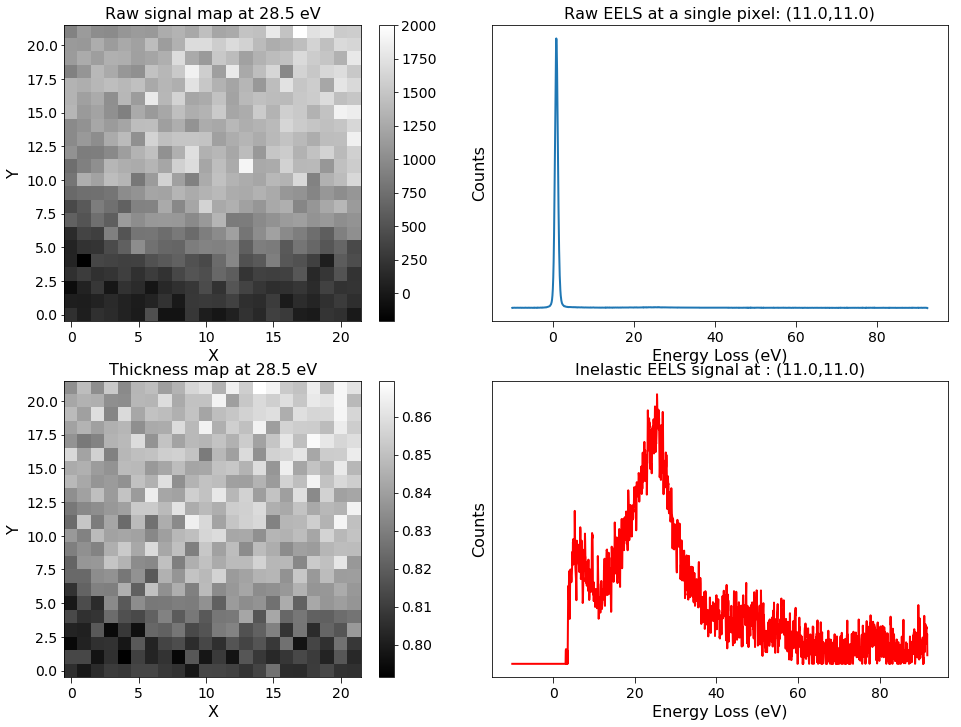

In [16]:
with h5py.File(h5_path, mode='r') as h5_file:
    # See if a tree has been created within the hdf5 file:
    px.hdf_utils.print_tree(h5_file)

    h5_proc = h5_file['Measurement_000/Channel_000/Processed/Processed_Data']
    h5_thick = h5_file['Measurement_000/Channel_000/Processed/Thickness'] 
    h5_main = h5_file['Measurement_000/Channel_000/Raw_Data']
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 12))
    
    ## 1st row for Plot Raw_Data
    # set check point in EELS to do the map:
    spec_point = 28.5
    data_point = (spec_point-spec_min)//spec_pixel_size + 1
    #print(data_point)
    #h5_main[()].shape
    spat_map = np.reshape(h5_main[:, data_point], (data_shape[0], data_shape[1]))
    px.plot_utils.plot_map(axes[0,0],spat_map, origin='lower')
    axes[0,0].set_title('Raw signal map at ' + str(spec_point) + ' eV')
    axes[0,0].set_xlabel('X')
    axes[0,0].set_ylabel('Y')  
    #set spatial point to check EELS:
    spat_point = [np.floor(data_shape[0]/2),np.floor(data_shape[1]/2)]
    axes[0,1].plot(np.linspace(spec_min, spec_min+spec_pixel_size*(h5_main.shape[1]-1), h5_main.shape[1]),
                 h5_main[spat_point[0]*data_shape[1]+spat_point[1]])
    axes[0,1].set_title('Raw EELS at a single pixel:'+' ('+str(spat_point[0])+','+str(spat_point[1])+')')
    axes[0,1].set_xlabel('Energy Loss (eV)')
    axes[0,1].set_ylabel('Counts');
    axes[0,1].set_yticks([])
    
    ## 2st row for Plot Processed_Data
    # set check point in EELS to do the map:
    spec_point = 28.5
    data_point = (spec_point-spec_min)//spec_pixel_size + 1
    #print(data_point)
    #h5_proc[()].shape
    #spat_map = np.reshape(h5_proc[:, data_point], (data_shape[0], data_shape[1]))
    px.plot_utils.plot_map(axes[1,0],h5_thick, origin='lower')
    axes[1,0].set_title('Thickness map at ' + str(spec_point) + ' eV')
    axes[1,0].set_xlabel('X')
    axes[1,0].set_ylabel('Y')
    #set spatial point to check EELS:
    spat_point = [np.floor(data_shape[0]/2),np.floor(data_shape[1]/2)]
    axes[1,1].plot(np.linspace(spec_min, spec_min+spec_pixel_size*(h5_proc.shape[1]-1), h5_proc.shape[1]),
                 h5_proc[spat_point[0]*data_shape[1]+spat_point[1]],'r')
    axes[1,1].set_title('Inelastic EELS signal at :'+' ('+str(spat_point[0])+','+str(spat_point[1])+')')
    axes[1,1].set_xlabel('Energy Loss (eV)')
    axes[1,1].set_ylabel('Counts');
    axes[1,1].set_yticks([])